##  Load and Preprocess EEG Data

### 1. Load .mat files


In [1]:
import numpy as np
import scipy.io
from scipy import signal
import os
from pathlib import Path
import pandas as pd
import mne
from mne.preprocessing import ICA

def load_mat_files(directory):
    """Load all .mat files from a directory into a dictionary"""
    data_dict = {}
    if not os.path.exists(directory):
        print(f"Directory {directory} not found")
        return data_dict
        
    for file in os.listdir(directory):
        if file.endswith('.mat'):
            file_path = os.path.join(directory, file)
            try:
                # Load the .mat file
                mat_data = scipy.io.loadmat(file_path)
                # Get the variable name from the file name 
                var_name = file.split('.')[0]
                # Extract the EEG data using the variable name as key
                eeg_data = mat_data[var_name]
                # Store in dictionary with filename as key
                data_dict[file] = eeg_data
                print(f"Successfully loaded {file} with shape {eeg_data.shape}")
            except Exception as e:
                print(f"Error loading {file}: {str(e)}")
    return data_dict


## 2. Preprocess EEG Data
1. Bandpass filter (1-50 Hz)
2. ICA for artifact removal 
3. Epoching

In [2]:

def preprocess_eeg(raw_data, sfreq=128):
    """
    Preprocess single subject EEG data with:
    1. Bandpass filter (1-50 Hz)
    2. ICA for artifact removal
    3. Epoching
    """
    # Create MNE Raw object
    ch_names = [f'EEG{i+1}' for i in range(raw_data.shape[1])]
    ch_types = ['eeg'] * raw_data.shape[1]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(raw_data.T, info)
    
    try:
        # Bandpass filter (1-50 Hz)
        raw_filtered = raw.copy().filter(l_freq=1, h_freq=50)
        
        # ICA for artifact removal
        ica = ICA(
            n_components=min(raw_data.shape[1] - 1, 15),
            random_state=42,
            max_iter=800
        )
        ica.fit(raw_filtered)
        raw_clean = raw_filtered.copy()
        ica.apply(raw_clean)
        
        #Create epochs (2-second epochs with 50% overlap)
        events = mne.make_fixed_length_events(
            raw_clean,
            duration=2.0,
            overlap=1.0
        )
        
        epochs = mne.Epochs(
            raw_clean,
            events,
            tmin=0,
            tmax=2,
            baseline=None,
            preload=True
        )
        
        epoched_data = epochs.get_data()
        print(f"Successfully preprocessed data: {epoched_data.shape}")
        return epoched_data
        
    except Exception as e:
        print(f"Error during preprocessing: {str(e)}")
        return None


## 3. Feature Extraction 
Extract 3 features 
1. PSD 
(Delta (1-4 Hz)
Theta (4-8 Hz)
Alpha (8-13 Hz)
Beta (13-30 Hz)
Gamma (30-45 Hz))
2. Theta/Beta Ratio (An elevated theta/beta ratio in the EEG has long been observed among individuals with ADHD)
3. Higuchi Fractal Dimension


In [3]:


def extract_features(epoched_data, sfreq=128):
    """
    Extract PSD, Theta/Beta Ratio, and Fractal Dimension features from epoched data
    
    Parameters:
    -----------
    epoched_data : numpy.ndarray
        Epoched data of shape (n_epochs, n_channels, n_timepoints)
    sfreq : float
        Sampling frequency
    
    Returns:
    --------
    list
        List of dictionaries containing features for all epochs
    """
    n_epochs, n_channels, n_timepoints = epoched_data.shape
    all_features = []
    
    # Process each epoch
    for epoch in range(n_epochs):
        epoch_features = {}
        
        # Process each channel
        for channel in range(n_channels):
            # Get channel data for current epoch
            data = epoched_data[epoch, channel]
            
            #Calculate PSD using Welch's method
            freqs, psd = signal.welch(data, fs=sfreq, nperseg=min(256, n_timepoints))
            
            # Calculate power in different frequency bands
            bands = {
                'delta': (1, 4),
                'theta': (4, 8),
                'alpha': (8, 13),
                'beta': (13, 30),
                'gamma': (30, 45)
            }
            
            for band_name, (fmin, fmax) in bands.items():
                # Find frequencies within band
                mask = (freqs >= fmin) & (freqs <= fmax)
                # Calculate average power in band
                power = np.mean(psd[mask])
                epoch_features[f'{band_name}_power_ch{channel}'] = power
            
            # Calculate Theta/Beta Ratio
            theta_mask = (freqs >= 4) & (freqs <= 8)
            beta_mask = (freqs >= 13) & (freqs <= 30)
            theta_power = np.mean(psd[theta_mask])
            beta_power = np.mean(psd[beta_mask])
            theta_beta_ratio = theta_power / beta_power if beta_power != 0 else 0
            epoch_features[f'theta_beta_ratio_ch{channel}'] = theta_beta_ratio
            
            # Calculate Higuchi Fractal Dimension
            def calculate_hfd(signal_data, kmax=10):
                N = len(signal_data)
                L = []
                x = []
                
                for k in range(1, kmax + 1):
                    Lk = 0
                    for m in range(k):
                        # Calculate length Lm(k)
                        Lmk = 0
                        for i in range(1, int((N - m) / k)):
                            Lmk += abs(signal_data[m + i * k] - signal_data[m + (i - 1) * k])
                        Lmk = Lmk * (N - 1) / (((N - m) / k) * k)
                        Lk += Lmk
                    L.append(np.log(Lk / k))
                    x.append(np.log(1.0 / k))
                
                # Fit line and get slope
                p = np.polyfit(x, L, 1)
                return -p[0]  # Fractal dimension is the negative of the slope
            
            hfd = calculate_hfd(data)
            epoch_features[f'fractal_dim_ch{channel}'] = hfd
            
        all_features.append(epoch_features)
    
    return all_features


**Note: Participant Wise Split**

**If split randomly at the epoch level, data from the same participant would appear in both training and testing. Since EEG signals have participant-specific patterns, the model may learn subject-specific biases rather than true generalizable features.**

In [4]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

def participant_wise_split(data_dict, test_size=0.2, random_state=42):
    """
    Split data at the participant level.
    
    Parameters:
    data_dict (dict): Dictionary with filenames as keys and EEG data as values.
    test_size (float): Proportion of participants to be in the test set.
    
    Returns:
    train_data, test_data (dict, dict): Dictionaries containing training and testing data.
    """
    # Extract participant IDs from filenames
    participant_ids = list(data_dict.keys())  # Assuming file names represent participants
    train_ids, test_ids = train_test_split(participant_ids, test_size=test_size, random_state=random_state)

    train_data = {key: data_dict[key] for key in train_ids}
    test_data = {key: data_dict[key] for key in test_ids}

    return train_data, test_data

def main():
    adhd_part1_path = Path('Dataset/ADHD_part1')
    adhd_part2_path = Path('Dataset/ADHD_part2')
    control_part1_path = Path('Dataset/Control_part1')
    control_part2_path = Path('Dataset/Control_part2')
    
    print("Loading ADHD group data...")
    adhd_data_part1 = load_mat_files(adhd_part1_path)
    adhd_data_part2 = load_mat_files(adhd_part2_path)
    
    print("Loading Control group data...")
    control_data_part1 = load_mat_files(control_part1_path)
    control_data_part2 = load_mat_files(control_part2_path)
    
    # Merge data for splitting
    all_adhd_data = {**adhd_data_part1, **adhd_data_part2}
    all_control_data = {**control_data_part1, **control_data_part2}

    # Participant-wise split
    adhd_train, adhd_test = participant_wise_split(all_adhd_data, test_size=0.2)
    control_train, control_test = participant_wise_split(all_control_data, test_size=0.2)

    # Initialize feature storage
    processed_features = {'train': [], 'test': []}

    # Process Train Data
    print("\nProcessing Training Data...")
    for dataset, label in [(adhd_train, 1), (control_train, 0)]:
        for file_name, eeg_data in dataset.items():
            try:
                processed = preprocess_eeg(eeg_data)
                if processed is not None:
                    features = extract_features(processed)
                    for feature in features:
                        feature['label'] = label
                    processed_features['train'].extend(features)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Process Test Data
    print("\nProcessing Testing Data...")
    for dataset, label in [(adhd_test, 1), (control_test, 0)]:
        for file_name, eeg_data in dataset.items():
            try:
                processed = preprocess_eeg(eeg_data)
                if processed is not None:
                    features = extract_features(processed)
                    for feature in features:
                        feature['label'] = label
                    processed_features['test'].extend(features)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Convert to DataFrame
    train_df = pd.DataFrame(processed_features['train'])
    test_df = pd.DataFrame(processed_features['test'])

    # Save Train & Test Features
    train_df.to_csv('eeg_train_features.csv', index=False)
    test_df.to_csv('eeg_test_features.csv', index=False)

    print("\nFeature extraction complete!")
    print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")
    
    return train_df, test_df

if __name__ == "__main__":
    train_features, test_features = main()


Loading ADHD group data...
Successfully loaded v10p.mat with shape (14304, 19)
Successfully loaded v12p.mat with shape (17604, 19)
Successfully loaded v14p.mat with shape (17562, 19)
Successfully loaded v15p.mat with shape (43252, 19)
Successfully loaded v173.mat with shape (24241, 19)
Successfully loaded v18p.mat with shape (25003, 19)
Successfully loaded v19p.mat with shape (23063, 19)
Successfully loaded v1p.mat with shape (12258, 19)
Successfully loaded v20p.mat with shape (35328, 19)
Successfully loaded v21p.mat with shape (16574, 19)
Successfully loaded v22p.mat with shape (12100, 19)
Successfully loaded v24p.mat with shape (16385, 19)
Successfully loaded v25p.mat with shape (9894, 19)
Successfully loaded v27p.mat with shape (28880, 19)
Successfully loaded v28p.mat with shape (27612, 19)
Successfully loaded v29p.mat with shape (24193, 19)
Successfully loaded v30p.mat with shape (21663, 19)
Successfully loaded v31p.mat with shape (11679, 19)
Successfully loaded v32p.mat with shape

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 336 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (336, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18657
    Range : 0 ... 18656 =      0.000 ...   145.750 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (144, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11679
    Range : 0 ... 11678 =      0.000 ...    91.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (90, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=35328
    Range : 0 ... 35327 =      0.000 ...   275.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 275 events and 257 original time points ...
1 bad epochs dropped
Successfully preprocessed data: (274, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=23063
    Range : 0 ... 23062 =      0.000 ...   180.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (179, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12353
    Range : 0 ... 12352 =      0.000 ...    96.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 95 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (95, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24241
    Range : 0 ... 24240 =      0.000 ...   189.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (188, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=28080
    Range : 0 ... 28079 =      0.000 ...   219.367 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
218 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 218 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (218, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=29217
    Range : 0 ... 29216 =      0.000 ...   228.250 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 227 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (227, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13502
    Range : 0 ... 13501 =      0.000 ...   105.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 104 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (104, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10477
    Range : 0 ... 10476 =      0.000 ...    81.844 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (80, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18177
    Range : 0 ... 18176 =      0.000 ...   142.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 12.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (141, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20134
    Range : 0 ... 20133 =      0.000 ...   157.289 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24193
    Range : 0 ... 24192 =      0.000 ...   189.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (188, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15383
    Range : 0 ... 15382 =      0.000 ...   120.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20097
    Range : 0 ... 20096 =      0.000 ...   157.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16574
    Range : 0 ... 16573 =      0.000 ...   129.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16697
    Range : 0 ... 16696 =      0.000 ...   130.438 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19621
    Range : 0 ... 19620 =      0.000 ...   153.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (152, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=33570
    Range : 0 ... 33569 =      0.000 ...   262.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 261 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (261, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24695
    Range : 0 ... 24694 =      0.000 ...   192.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (191, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=27157
    Range : 0 ... 27156 =      0.000 ...   212.156 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
211 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 211 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (211, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16385
    Range : 0 ... 16384 =      0.000 ...   128.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 127 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (127, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10668
    Range : 0 ... 10667 =      0.000 ...    83.336 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (82, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18389
    Range : 0 ... 18388 =      0.000 ...   143.656 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 142 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (142, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17323
    Range : 0 ... 17322 =      0.000 ...   135.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (134, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12739
    Range : 0 ... 12738 =      0.000 ...    99.516 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15776
    Range : 0 ... 15775 =      0.000 ...   123.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (122, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19713
    Range : 0 ... 19712 =      0.000 ...   154.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (153, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17604
    Range : 0 ... 17603 =      0.000 ...   137.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15305
    Range : 0 ... 15304 =      0.000 ...   119.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 118 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (118, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17562
    Range : 0 ... 17561 =      0.000 ...   137.195 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9852
    Range : 0 ... 9851 =      0.000 ...    76.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (75, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20173
    Range : 0 ... 20172 =      0.000 ...   157.594 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13395
    Range : 0 ... 13394 =      0.000 ...   104.641 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 8.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9286
    Range : 0 ... 9285 =      0.000 ...    72.539 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting bac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 71 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (71, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21307
    Range : 0 ... 21306 =      0.000 ...   166.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (165, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12100
    Range : 0 ... 12099 =      0.000 ...    94.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 93 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (93, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17401
    Range : 0 ... 17400 =      0.000 ...   135.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (134, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18049
    Range : 0 ... 18048 =      0.000 ...   141.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (140, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20115
    Range : 0 ... 20114 =      0.000 ...   157.141 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19555
    Range : 0 ... 19554 =      0.000 ...   152.766 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (151, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12258
    Range : 0 ... 12257 =      0.000 ...    95.758 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (94, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21372
    Range : 0 ... 21371 =      0.000 ...   166.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (165, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=27612
    Range : 0 ... 27611 =      0.000 ...   215.711 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 214 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (214, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17561
    Range : 0 ... 17560 =      0.000 ...   137.188 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13853
    Range : 0 ... 13852 =      0.000 ...   108.219 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20456
    Range : 0 ... 20455 =      0.000 ...   159.805 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (158, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12007
    Range : 0 ... 12006 =      0.000 ...    93.797 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (92, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16549
    Range : 0 ... 16548 =      0.000 ...   129.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19222
    Range : 0 ... 19221 =      0.000 ...   150.164 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10452
    Range : 0 ... 10451 =      0.000 ...    81.648 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (80, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15651
    Range : 0 ... 15650 =      0.000 ...   122.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (121, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15574
    Range : 0 ... 15573 =      0.000 ...   121.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (120, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13359
    Range : 0 ... 13358 =      0.000 ...   104.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15310
    Range : 0 ... 15309 =      0.000 ...   119.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 118 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (118, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15607
    Range : 0 ... 15606 =      0.000 ...   121.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (120, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16239
    Range : 0 ... 16238 =      0.000 ...   126.859 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (125, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14550
    Range : 0 ... 14549 =      0.000 ...   113.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 112 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (112, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24818
    Range : 0 ... 24817 =      0.000 ...   193.883 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (192, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14139
    Range : 0 ... 14138 =      0.000 ...   110.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 109 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (109, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22807
    Range : 0 ... 22806 =      0.000 ...   178.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
177 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 177 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (177, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9823
    Range : 0 ... 9822 =      0.000 ...    76.734 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (75, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13918
    Range : 0 ... 13917 =      0.000 ...   108.727 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19301
    Range : 0 ... 19300 =      0.000 ...   150.781 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25659
    Range : 0 ... 25658 =      0.000 ...   200.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 199 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (199, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14692
    Range : 0 ... 14691 =      0.000 ...   114.773 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 113 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (113, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10864
    Range : 0 ... 10863 =      0.000 ...    84.867 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (83, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14282
    Range : 0 ... 14281 =      0.000 ...   111.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18301
    Range : 0 ... 18300 =      0.000 ...   142.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 11.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (141, 19, 257)


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Creating RawArray with float64 data, n_channels=19, n_times=16704
    Range : 0 ... 16703 =      0.000 ...   130.492 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12033
    Range : 0 ... 12032 =      0.000 ...    94.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 93 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (93, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13400
    Range : 0 ... 13399 =      0.000 ...   104.680 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12488
    Range : 0 ... 12487 =      0.000 ...    97.555 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (96, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11208
    Range : 0 ... 11207 =      0.000 ...    87.555 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (86, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12929
    Range : 0 ... 12928 =      0.000 ...   101.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (100, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14209
    Range : 0 ... 14208 =      0.000 ...   111.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19026
    Range : 0 ... 19025 =      0.000 ...   148.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (147, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13883
    Range : 0 ... 13882 =      0.000 ...   108.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16044
    Range : 0 ... 16043 =      0.000 ...   125.336 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 124 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (124, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13697
    Range : 0 ... 13696 =      0.000 ...   107.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 106 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (106, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15073
    Range : 0 ... 15072 =      0.000 ...   117.750 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (116, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15378
    Range : 0 ... 15377 =      0.000 ...   120.133 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19234
    Range : 0 ... 19233 =      0.000 ...   150.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22260
    Range : 0 ... 22259 =      0.000 ...   173.898 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (172, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    97.648 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (96, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19122
    Range : 0 ... 19121 =      0.000 ...   149.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (148, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16769
    Range : 0 ... 16768 =      0.000 ...   131.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 130 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (130, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17793
    Range : 0 ... 17792 =      0.000 ...   139.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (138, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (61, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13304
    Range : 0 ... 13303 =      0.000 ...   103.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 102 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (102, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17187
    Range : 0 ... 17186 =      0.000 ...   134.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 133 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (133, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10871
    Range : 0 ... 10870 =      0.000 ...    84.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (83, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16513
    Range : 0 ... 16512 =      0.000 ...   129.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17841
    Range : 0 ... 17840 =      0.000 ...   139.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (138, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16686
    Range : 0 ... 16685 =      0.000 ...   130.352 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)

Processing Testing Data...
Creating RawArray with float64 data, n_channels=19, n_times=14304
    Range : 0 ... 14303 =      0.000 ...   111.742 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25003
    Range : 0 ... 25002 =      0.000 ...   195.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (194, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=34191
    Range : 0 ... 34190 =      0.000 ...   267.109 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 266 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (266, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12673
    Range : 0 ... 12672 =      0.000 ...    99.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=28880
    Range : 0 ... 28879 =      0.000 ...   225.617 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (224, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=23681
    Range : 0 ... 23680 =      0.000 ...   185.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (184, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15465
    Range : 0 ... 15464 =      0.000 ...   120.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=39030
    Range : 0 ... 39029 =      0.000 ...   304.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 303 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (303, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9894
    Range : 0 ... 9893 =      0.000 ...    77.289 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (76, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=30273
    Range : 0 ... 30272 =      0.000 ...   236.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 235 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (235, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18591
    Range : 0 ... 18590 =      0.000 ...   145.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (144, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11465
    Range : 0 ... 11464 =      0.000 ...    89.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (88, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21663
    Range : 0 ... 21662 =      0.000 ...   169.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (168, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19794
    Range : 0 ... 19793 =      0.000 ...   154.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (153, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15943
    Range : 0 ... 15942 =      0.000 ...   124.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (123, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14721
    Range : 0 ... 14720 =      0.000 ...   115.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (114, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17098
    Range : 0 ... 17097 =      0.000 ...   133.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (132, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11393
    Range : 0 ... 11392 =      0.000 ...    89.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 projection items activated
Using data from preloaded Raw for 88 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (88, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22273
    Range : 0 ... 22272 =      0.000 ...   174.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
173 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 173 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (173, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16377
    Range : 0 ... 16376 =      0.000 ...   127.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 126 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (126, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17782
    Range : 0 ... 17781 =      0.000 ...   138.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 137 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (137, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12750
    Range : 0 ... 12749 =      0.000 ...    99.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17025
    Range : 0 ... 17024 =      0.000 ...   133.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (132, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20914
    Range : 0 ... 20913 =      0.000 ...   163.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 162 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (162, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25985
    Range : 0 ... 25984 =      0.000 ...   203.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 202 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (202, 19, 257)

Feature extraction complete!
Training samples: 12899, Testing samples: 3849


## 4. Classifier Implementation (Theta:Beta Ratio) - KNN

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

Loading pre-split train and test features...

Data shapes:
Training set: (12899, 133)
Test set: (3849, 133)

Finding optimal K value...


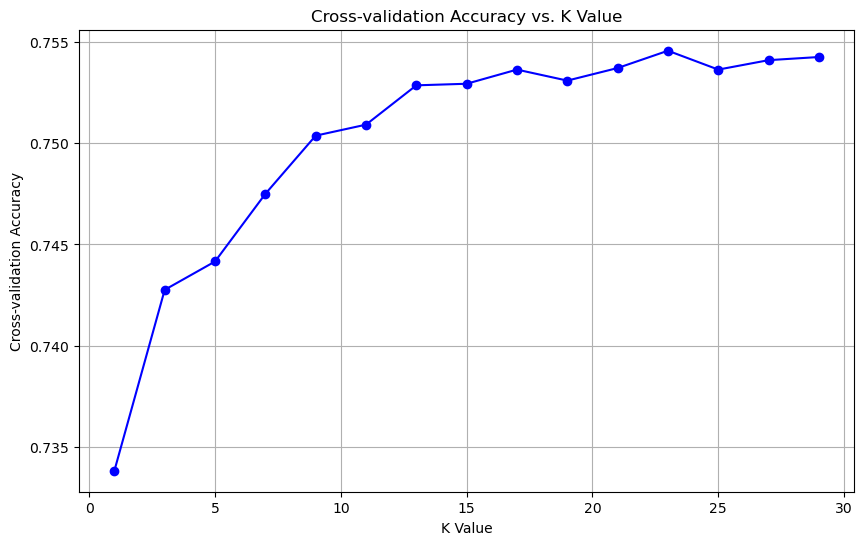


Optimal K value: 23
Best cross-validation accuracy: 0.7545

Training KNN with optimal K...

Test Set Accuracy: 0.7316

Classification Report:
              precision    recall  f1-score   support

     Control       0.71      0.63      0.67      1640
        ADHD       0.75      0.80      0.77      2209

    accuracy                           0.73      3849
   macro avg       0.73      0.72      0.72      3849
weighted avg       0.73      0.73      0.73      3849


Plotting confusion matrix...


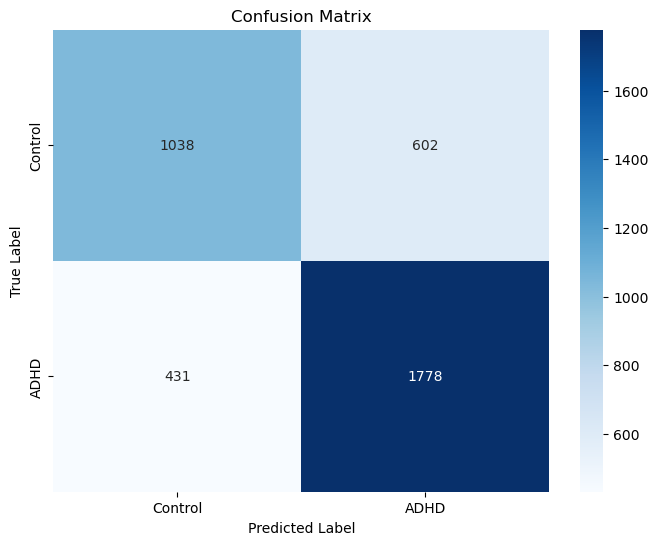


Performing grid search for hyperparameter tuning...

Grid Search Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'distance'}
Best cross-validation accuracy: 0.7704

Training final model with best parameters...

Final Model Results:
Test Set Accuracy: 0.7267

Classification Report:
              precision    recall  f1-score   support

     Control       0.69      0.64      0.67      1640
        ADHD       0.75      0.79      0.77      2209

    accuracy                           0.73      3849
   macro avg       0.72      0.72      0.72      3849
weighted avg       0.72      0.73      0.73      3849


Plotting final confusion matrix...


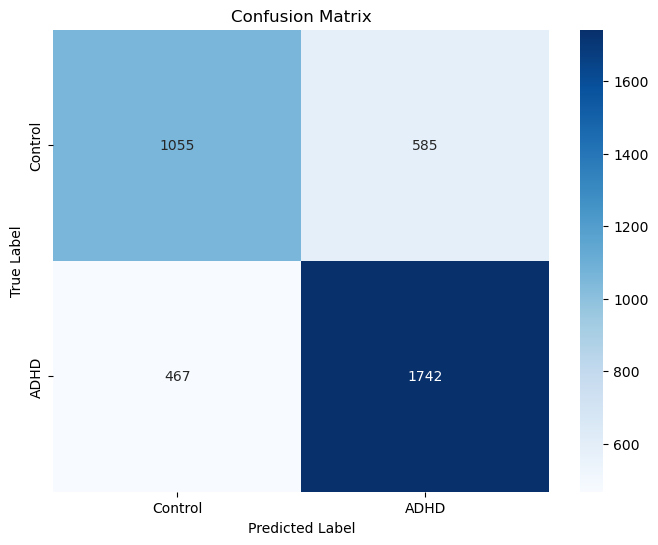


Model and scaler saved as 'knn_model.joblib' and 'knn_scaler.joblib'


In [7]:


def find_optimal_k(X_train, y_train, k_range=range(1, 31, 2)):
    """
    Find the optimal K value using cross-validation
    """
    cv_scores = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, cv_scores, 'bo-')
    plt.title('Cross-validation Accuracy vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Cross-validation Accuracy')
    plt.grid(True)
    plt.show()
    
    # Get the optimal K value
    optimal_k = k_range[np.argmax(cv_scores)]
    print(f"\nOptimal K value: {optimal_k}")
    print(f"Best cross-validation accuracy: {max(cv_scores):.4f}")
    
    return optimal_k

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Control', 'ADHD'],
        yticklabels=['Control', 'ADHD']
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main():
    # Load the pre-split data
    print("Loading pre-split train and test features...")
    train_df = pd.read_csv('eeg_train_features.csv')
    test_df = pd.read_csv('eeg_test_features.csv')
    
    # Prepare the data
    X_train = train_df.drop('label', axis=1).values
    y_train = train_df['label'].values
    X_test = test_df.drop('label', axis=1).values
    y_test = test_df['label'].values
    
    print("\nData shapes:")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Find optimal K value
    print("\nFinding optimal K value...")
    optimal_k = find_optimal_k(X_train_scaled, y_train)
    
    # Train KNN with optimal K
    print("\nTraining KNN with optimal K...")
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Set Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Control', 'ADHD']))
    
    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(y_test, y_pred)
    
    # Perform grid search for fine-tuning
    print("\nPerforming grid search for hyperparameter tuning...")
    param_grid = {
        'n_neighbors': [optimal_k-2, optimal_k-1, optimal_k, optimal_k+1, optimal_k+2],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print("\nGrid Search Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    print("\nTraining final model with best parameters...")
    best_knn = KNeighborsClassifier(**grid_search.best_params_)
    best_knn.fit(X_train_scaled, y_train)
    
    # Evaluate final model
    final_predictions = best_knn.predict(X_test_scaled)
    final_accuracy = accuracy_score(y_test, final_predictions)
    
    print("\nFinal Model Results:")
    print(f"Test Set Accuracy: {final_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, final_predictions, target_names=['Control', 'ADHD']))
    
    # Plot final confusion matrix
    print("\nPlotting final confusion matrix...")
    plot_confusion_matrix(y_test, final_predictions)
    
    # Save the best model and scaler
    import joblib
    joblib.dump(best_knn, 'knn_model.joblib')
    joblib.dump(scaler, 'knn_scaler.joblib')
    print("\nModel and scaler saved as 'knn_model.joblib' and 'knn_scaler.joblib'")

if __name__ == '__main__':
    main()

## 3. Feature Extraction - 2 (Alpha)
Extract 3 features 
1. PSD 
(Delta (1-4 Hz)
Theta (4-8 Hz)
Alpha (8-13 Hz)
Beta (13-30 Hz)
Gamma (30-45 Hz))
2. Alpha (An elevated Alpha (8-13HZ) in the EEG has long been observed among individuals with ADHD)
3. Higuchi Fractal Dimension

In [8]:


def extract_features_2(epoched_data, sfreq=128):
    """
    Extract PSD, Alpha, and Fractal Dimension features from epoched data
    
    Parameters:
    -----------
    epoched_data : numpy.ndarray
        Epoched data of shape (n_epochs, n_channels, n_timepoints)
    sfreq : float
        Sampling frequency
    
    Returns:
    --------
    list
        List of dictionaries containing features for all epochs
    """
    n_epochs, n_channels, n_timepoints = epoched_data.shape
    all_features = []
    
    # Process each epoch
    for epoch in range(n_epochs):
        epoch_features = {}
        
        # Process each channel
        for channel in range(n_channels):
            # Get channel data for current epoch
            data = epoched_data[epoch, channel]
            
            #Calculate PSD using Welch's method
            freqs, psd = signal.welch(data, fs=sfreq, nperseg=min(256, n_timepoints))
            
            # Calculate power in different frequency bands
            bands = {
                'delta': (1, 4),
                'theta': (4, 8),
                'alpha': (8, 13),
                'beta': (13, 30),
                'gamma': (30, 45)
            }
            
            for band_name, (fmin, fmax) in bands.items():
                # Find frequencies within band
                mask = (freqs >= fmin) & (freqs <= fmax)
                # Calculate average power in band
                power = np.mean(psd[mask])
                epoch_features[f'{band_name}_power_ch{channel}'] = power
            
            # Calculate Alpha
            alpha = (freqs >= 8) & (freqs <= 13)
            alpha_power = np.mean(psd[alpha])
            # beta_mask = (freqs >= 13) & (freqs <= 30)
            # theta_power = np.mean(psd[theta_mask])
            # beta_power = np.mean(psd[beta_mask])
            # theta_beta_ratio = theta_power / beta_power if beta_power != 0 else 0
            epoch_features[f'Alpha_ch{channel}'] = alpha_power
            
            # Calculate Higuchi Fractal Dimension
            def calculate_hfd(signal_data, kmax=10):
                N = len(signal_data)
                L = []
                x = []
                
                for k in range(1, kmax + 1):
                    Lk = 0
                    for m in range(k):
                        # Calculate length Lm(k)
                        Lmk = 0
                        for i in range(1, int((N - m) / k)):
                            Lmk += abs(signal_data[m + i * k] - signal_data[m + (i - 1) * k])
                        Lmk = Lmk * (N - 1) / (((N - m) / k) * k)
                        Lk += Lmk
                    L.append(np.log(Lk / k))
                    x.append(np.log(1.0 / k))
                
                # Fit line and get slope
                p = np.polyfit(x, L, 1)
                return -p[0]  # Fractal dimension is the negative of the slope
            
            hfd = calculate_hfd(data)
            epoch_features[f'fractal_dim_ch{channel}'] = hfd
            
        all_features.append(epoch_features)
    
    return all_features


In [9]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

def main():
    adhd_part1_path = Path('Dataset/ADHD_part1')
    adhd_part2_path = Path('Dataset/ADHD_part2')
    control_part1_path = Path('Dataset/Control_part1')
    control_part2_path = Path('Dataset/Control_part2')
    
    print("Loading ADHD group data...")
    adhd_data_part1 = load_mat_files(adhd_part1_path)
    adhd_data_part2 = load_mat_files(adhd_part2_path)
    
    print("Loading Control group data...")
    control_data_part1 = load_mat_files(control_part1_path)
    control_data_part2 = load_mat_files(control_part2_path)
    
    # Merge data for splitting
    all_adhd_data = {**adhd_data_part1, **adhd_data_part2}
    all_control_data = {**control_data_part1, **control_data_part2}

    # Participant-wise split
    adhd_train, adhd_test = participant_wise_split(all_adhd_data, test_size=0.2)
    control_train, control_test = participant_wise_split(all_control_data, test_size=0.2)

    # Initialize feature storage
    processed_features = {'train': [], 'test': []}

    # Process Train Data
    print("\nProcessing Training Data...")
    for dataset, label in [(adhd_train, 1), (control_train, 0)]:
        for file_name, eeg_data in dataset.items():
            try:
                processed = preprocess_eeg(eeg_data)
                if processed is not None:
                    features = extract_features_2(processed)
                    for feature in features:
                        feature['label'] = label
                    processed_features['train'].extend(features)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Process Test Data
    print("\nProcessing Testing Data...")
    for dataset, label in [(adhd_test, 1), (control_test, 0)]:
        for file_name, eeg_data in dataset.items():
            try:
                processed = preprocess_eeg(eeg_data)
                if processed is not None:
                    features = extract_features_2(processed)
                    for feature in features:
                        feature['label'] = label
                    processed_features['test'].extend(features)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Convert to DataFrame
    train_df = pd.DataFrame(processed_features['train'])
    test_df = pd.DataFrame(processed_features['test'])

    # Save Train & Test Features
    train_df.to_csv('eeg_train_features.csv', index=False)
    test_df.to_csv('eeg_test_features.csv', index=False)

    print("\nFeature extraction_2 complete!")
    print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")
    
    return train_df, test_df

if __name__ == "__main__":
    train_features, test_features = main()


Loading ADHD group data...
Successfully loaded v10p.mat with shape (14304, 19)
Successfully loaded v12p.mat with shape (17604, 19)
Successfully loaded v14p.mat with shape (17562, 19)
Successfully loaded v15p.mat with shape (43252, 19)
Successfully loaded v173.mat with shape (24241, 19)
Successfully loaded v18p.mat with shape (25003, 19)
Successfully loaded v19p.mat with shape (23063, 19)
Successfully loaded v1p.mat with shape (12258, 19)
Successfully loaded v20p.mat with shape (35328, 19)
Successfully loaded v21p.mat with shape (16574, 19)
Successfully loaded v22p.mat with shape (12100, 19)
Successfully loaded v24p.mat with shape (16385, 19)
Successfully loaded v25p.mat with shape (9894, 19)
Successfully loaded v27p.mat with shape (28880, 19)
Successfully loaded v28p.mat with shape (27612, 19)
Successfully loaded v29p.mat with shape (24193, 19)
Successfully loaded v30p.mat with shape (21663, 19)
Successfully loaded v31p.mat with shape (11679, 19)
Successfully loaded v32p.mat with shape

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 336 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (336, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18657
    Range : 0 ... 18656 =      0.000 ...   145.750 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (144, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11679
    Range : 0 ... 11678 =      0.000 ...    91.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (90, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=35328
    Range : 0 ... 35327 =      0.000 ...   275.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 275 events and 257 original time points ...
1 bad epochs dropped
Successfully preprocessed data: (274, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=23063
    Range : 0 ... 23062 =      0.000 ...   180.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (179, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12353
    Range : 0 ... 12352 =      0.000 ...    96.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 95 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (95, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24241
    Range : 0 ... 24240 =      0.000 ...   189.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (188, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=28080
    Range : 0 ... 28079 =      0.000 ...   219.367 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
218 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 218 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (218, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=29217
    Range : 0 ... 29216 =      0.000 ...   228.250 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 227 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (227, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13502
    Range : 0 ... 13501 =      0.000 ...   105.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 104 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (104, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10477
    Range : 0 ... 10476 =      0.000 ...    81.844 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (80, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18177
    Range : 0 ... 18176 =      0.000 ...   142.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 12.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (141, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20134
    Range : 0 ... 20133 =      0.000 ...   157.289 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24193
    Range : 0 ... 24192 =      0.000 ...   189.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (188, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15383
    Range : 0 ... 15382 =      0.000 ...   120.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20097
    Range : 0 ... 20096 =      0.000 ...   157.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16574
    Range : 0 ... 16573 =      0.000 ...   129.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16697
    Range : 0 ... 16696 =      0.000 ...   130.438 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19621
    Range : 0 ... 19620 =      0.000 ...   153.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (152, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=33570
    Range : 0 ... 33569 =      0.000 ...   262.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 261 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (261, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24695
    Range : 0 ... 24694 =      0.000 ...   192.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (191, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=27157
    Range : 0 ... 27156 =      0.000 ...   212.156 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
211 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 211 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (211, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16385
    Range : 0 ... 16384 =      0.000 ...   128.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 127 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (127, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10668
    Range : 0 ... 10667 =      0.000 ...    83.336 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (82, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18389
    Range : 0 ... 18388 =      0.000 ...   143.656 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 142 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (142, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17323
    Range : 0 ... 17322 =      0.000 ...   135.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (134, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12739
    Range : 0 ... 12738 =      0.000 ...    99.516 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15776
    Range : 0 ... 15775 =      0.000 ...   123.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (122, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19713
    Range : 0 ... 19712 =      0.000 ...   154.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (153, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17604
    Range : 0 ... 17603 =      0.000 ...   137.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15305
    Range : 0 ... 15304 =      0.000 ...   119.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 118 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (118, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17562
    Range : 0 ... 17561 =      0.000 ...   137.195 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9852
    Range : 0 ... 9851 =      0.000 ...    76.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (75, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20173
    Range : 0 ... 20172 =      0.000 ...   157.594 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13395
    Range : 0 ... 13394 =      0.000 ...   104.641 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 8.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9286
    Range : 0 ... 9285 =      0.000 ...    72.539 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting bac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 projection items activated
Using data from preloaded Raw for 71 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (71, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21307
    Range : 0 ... 21306 =      0.000 ...   166.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (165, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12100
    Range : 0 ... 12099 =      0.000 ...    94.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 93 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (93, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17401
    Range : 0 ... 17400 =      0.000 ...   135.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (134, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18049
    Range : 0 ... 18048 =      0.000 ...   141.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (140, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20115
    Range : 0 ... 20114 =      0.000 ...   157.141 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19555
    Range : 0 ... 19554 =      0.000 ...   152.766 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (151, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12258
    Range : 0 ... 12257 =      0.000 ...    95.758 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (94, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21372
    Range : 0 ... 21371 =      0.000 ...   166.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (165, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=27612
    Range : 0 ... 27611 =      0.000 ...   215.711 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 214 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (214, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17561
    Range : 0 ... 17560 =      0.000 ...   137.188 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13853
    Range : 0 ... 13852 =      0.000 ...   108.219 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20456
    Range : 0 ... 20455 =      0.000 ...   159.805 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (158, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12007
    Range : 0 ... 12006 =      0.000 ...    93.797 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (92, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16549
    Range : 0 ... 16548 =      0.000 ...   129.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19222
    Range : 0 ... 19221 =      0.000 ...   150.164 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10452
    Range : 0 ... 10451 =      0.000 ...    81.648 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (80, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15651
    Range : 0 ... 15650 =      0.000 ...   122.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (121, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15574
    Range : 0 ... 15573 =      0.000 ...   121.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (120, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13359
    Range : 0 ... 13358 =      0.000 ...   104.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15310
    Range : 0 ... 15309 =      0.000 ...   119.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 118 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (118, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15607
    Range : 0 ... 15606 =      0.000 ...   121.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (120, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16239
    Range : 0 ... 16238 =      0.000 ...   126.859 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (125, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14550
    Range : 0 ... 14549 =      0.000 ...   113.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 112 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (112, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24818
    Range : 0 ... 24817 =      0.000 ...   193.883 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (192, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14139
    Range : 0 ... 14138 =      0.000 ...   110.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 109 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (109, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22807
    Range : 0 ... 22806 =      0.000 ...   178.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
177 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 177 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (177, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9823
    Range : 0 ... 9822 =      0.000 ...    76.734 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (75, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13918
    Range : 0 ... 13917 =      0.000 ...   108.727 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19301
    Range : 0 ... 19300 =      0.000 ...   150.781 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25659
    Range : 0 ... 25658 =      0.000 ...   200.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 199 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (199, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14692
    Range : 0 ... 14691 =      0.000 ...   114.773 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 113 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (113, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10864
    Range : 0 ... 10863 =      0.000 ...    84.867 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (83, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14282
    Range : 0 ... 14281 =      0.000 ...   111.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18301
    Range : 0 ... 18300 =      0.000 ...   142.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 11.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (141, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16704
    Range : 0 ... 16703 =      0.000 ...   130.492 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12033
    Range : 0 ... 12032 =      0.000 ...    94.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 93 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (93, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13400
    Range : 0 ... 13399 =      0.000 ...   104.680 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12488
    Range : 0 ... 12487 =      0.000 ...    97.555 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (96, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11208
    Range : 0 ... 11207 =      0.000 ...    87.555 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (86, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12929
    Range : 0 ... 12928 =      0.000 ...   101.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (100, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14209
    Range : 0 ... 14208 =      0.000 ...   111.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19026
    Range : 0 ... 19025 =      0.000 ...   148.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (147, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13883
    Range : 0 ... 13882 =      0.000 ...   108.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16044
    Range : 0 ... 16043 =      0.000 ...   125.336 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 124 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (124, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13697
    Range : 0 ... 13696 =      0.000 ...   107.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 106 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (106, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15073
    Range : 0 ... 15072 =      0.000 ...   117.750 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (116, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15378
    Range : 0 ... 15377 =      0.000 ...   120.133 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19234
    Range : 0 ... 19233 =      0.000 ...   150.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22260
    Range : 0 ... 22259 =      0.000 ...   173.898 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (172, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    97.648 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (96, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19122
    Range : 0 ... 19121 =      0.000 ...   149.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (148, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16769
    Range : 0 ... 16768 =      0.000 ...   131.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 130 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (130, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17793
    Range : 0 ... 17792 =      0.000 ...   139.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (138, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (61, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13304
    Range : 0 ... 13303 =      0.000 ...   103.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 102 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (102, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17187
    Range : 0 ... 17186 =      0.000 ...   134.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 133 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (133, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10871
    Range : 0 ... 10870 =      0.000 ...    84.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (83, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16513
    Range : 0 ... 16512 =      0.000 ...   129.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17841
    Range : 0 ... 17840 =      0.000 ...   139.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (138, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16686
    Range : 0 ... 16685 =      0.000 ...   130.352 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)

Processing Testing Data...
Creating RawArray with float64 data, n_channels=19, n_times=14304
    Range : 0 ... 14303 =      0.000 ...   111.742 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25003
    Range : 0 ... 25002 =      0.000 ...   195.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (194, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=34191
    Range : 0 ... 34190 =      0.000 ...   267.109 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 266 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (266, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12673
    Range : 0 ... 12672 =      0.000 ...    99.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=28880
    Range : 0 ... 28879 =      0.000 ...   225.617 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (224, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=23681
    Range : 0 ... 23680 =      0.000 ...   185.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (184, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15465
    Range : 0 ... 15464 =      0.000 ...   120.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=39030
    Range : 0 ... 39029 =      0.000 ...   304.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 303 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (303, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9894
    Range : 0 ... 9893 =      0.000 ...    77.289 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (76, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=30273
    Range : 0 ... 30272 =      0.000 ...   236.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 235 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (235, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18591
    Range : 0 ... 18590 =      0.000 ...   145.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (144, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11465
    Range : 0 ... 11464 =      0.000 ...    89.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (88, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21663
    Range : 0 ... 21662 =      0.000 ...   169.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (168, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19794
    Range : 0 ... 19793 =      0.000 ...   154.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (153, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15943
    Range : 0 ... 15942 =      0.000 ...   124.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (123, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14721
    Range : 0 ... 14720 =      0.000 ...   115.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (114, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17098
    Range : 0 ... 17097 =      0.000 ...   133.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (132, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11393
    Range : 0 ... 11392 =      0.000 ...    89.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (88, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22273
    Range : 0 ... 22272 =      0.000 ...   174.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
173 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 173 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (173, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16377
    Range : 0 ... 16376 =      0.000 ...   127.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 126 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (126, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17782
    Range : 0 ... 17781 =      0.000 ...   138.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 137 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (137, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12750
    Range : 0 ... 12749 =      0.000 ...    99.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17025
    Range : 0 ... 17024 =      0.000 ...   133.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (132, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20914
    Range : 0 ... 20913 =      0.000 ...   163.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 162 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (162, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25985
    Range : 0 ... 25984 =      0.000 ...   203.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 202 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (202, 19, 257)

Feature extraction_2 complete!
Training samples: 12899, Testing samples: 3849


### KNN - Alpha

Loading pre-split train and test features...

Data shapes:
Training set: (12899, 38)
Test set: (3849, 38)

Finding optimal K value...


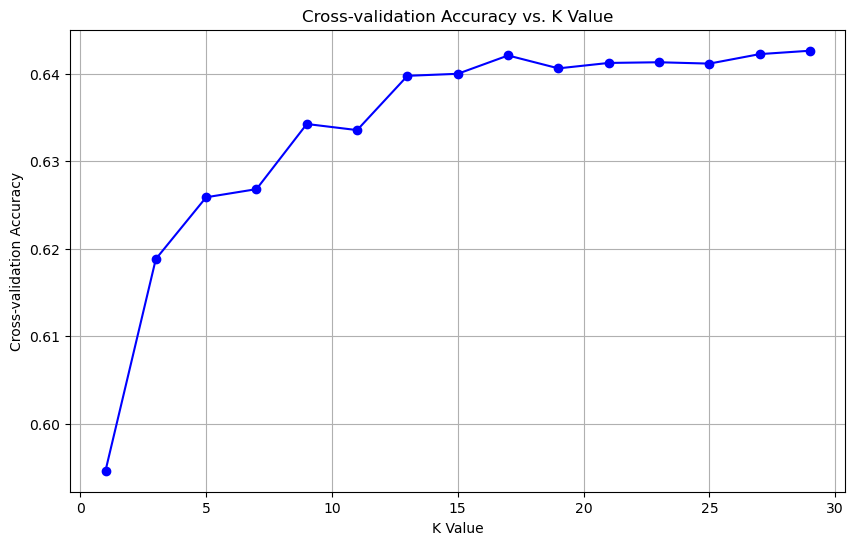


Optimal K value: 29
Best cross-validation accuracy: 0.6426

Training KNN with optimal K...

Test Set Accuracy: 0.6272

Classification Report:
              precision    recall  f1-score   support

     Control       0.59      0.39      0.47      1640
        ADHD       0.64      0.80      0.71      2209

    accuracy                           0.63      3849
   macro avg       0.62      0.60      0.59      3849
weighted avg       0.62      0.63      0.61      3849


Plotting confusion matrix...


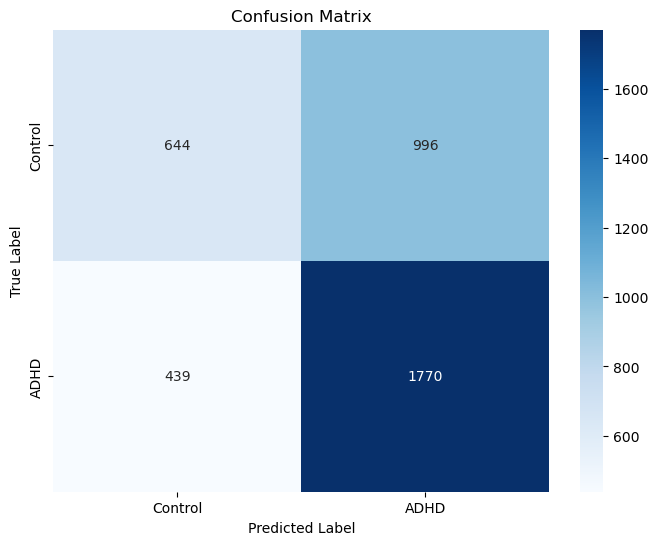


Performing grid search for hyperparameter tuning...

Grid Search Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
Best cross-validation accuracy: 0.6509

Training final model with best parameters...

Final Model Results:
Test Set Accuracy: 0.6303

Classification Report:
              precision    recall  f1-score   support

     Control       0.60      0.39      0.47      1640
        ADHD       0.64      0.81      0.71      2209

    accuracy                           0.63      3849
   macro avg       0.62      0.60      0.59      3849
weighted avg       0.62      0.63      0.61      3849


Plotting final confusion matrix...


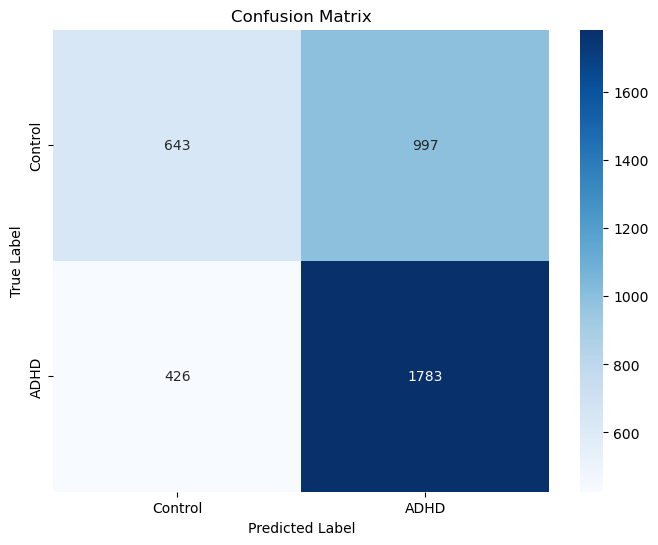


Model and scaler saved as 'knn_model.joblib' and 'knn_scaler.joblib'


In [10]:


def find_optimal_k(X_train, y_train, k_range=range(1, 31, 2)):
    """
    Find the optimal K value using cross-validation
    """
    cv_scores = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, cv_scores, 'bo-')
    plt.title('Cross-validation Accuracy vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Cross-validation Accuracy')
    plt.grid(True)
    plt.show()
    
    # Get the optimal K value
    optimal_k = k_range[np.argmax(cv_scores)]
    print(f"\nOptimal K value: {optimal_k}")
    print(f"Best cross-validation accuracy: {max(cv_scores):.4f}")
    
    return optimal_k

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Control', 'ADHD'],
        yticklabels=['Control', 'ADHD']
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main():
    # Load the pre-split data
    print("Loading pre-split train and test features...")
    train_df = pd.read_csv('eeg_train_features.csv')
    test_df = pd.read_csv('eeg_test_features.csv')
    
    # Separate features and labels
    X_train = train_df[['alpha_power_ch0', 'Alpha_ch0', 'alpha_power_ch1', 'Alpha_ch1', 'alpha_power_ch2', 'Alpha_ch2',
                        'alpha_power_ch3', 'Alpha_ch3', 'alpha_power_ch4', 'Alpha_ch4', 'alpha_power_ch5', 'Alpha_ch5', 
                        'alpha_power_ch6', 'Alpha_ch6', 'alpha_power_ch7', 'Alpha_ch7', 'alpha_power_ch8','Alpha_ch8', 
                        'alpha_power_ch9', 'Alpha_ch9', 'alpha_power_ch10', 'Alpha_ch10', 'alpha_power_ch11',  'Alpha_ch11',
                        'alpha_power_ch12', 'Alpha_ch12', 'alpha_power_ch13', 'Alpha_ch13', 'alpha_power_ch14', 'Alpha_ch14', 
                        'alpha_power_ch15', 'Alpha_ch15', 'alpha_power_ch16', 'Alpha_ch16', 'alpha_power_ch17', 'Alpha_ch17',
                        'alpha_power_ch18', 'Alpha_ch18']]
    y_train = train_df['label']
    X_test = test_df[['alpha_power_ch0', 'Alpha_ch0', 'alpha_power_ch1', 'Alpha_ch1', 'alpha_power_ch2', 'Alpha_ch2',
                        'alpha_power_ch3', 'Alpha_ch3', 'alpha_power_ch4', 'Alpha_ch4', 'alpha_power_ch5', 'Alpha_ch5', 
                        'alpha_power_ch6', 'Alpha_ch6', 'alpha_power_ch7', 'Alpha_ch7', 'alpha_power_ch8','Alpha_ch8', 
                        'alpha_power_ch9', 'Alpha_ch9', 'alpha_power_ch10', 'Alpha_ch10', 'alpha_power_ch11',  'Alpha_ch11',
                        'alpha_power_ch12', 'Alpha_ch12', 'alpha_power_ch13', 'Alpha_ch13', 'alpha_power_ch14', 'Alpha_ch14', 
                        'alpha_power_ch15', 'Alpha_ch15', 'alpha_power_ch16', 'Alpha_ch16', 'alpha_power_ch17', 'Alpha_ch17',
                        'alpha_power_ch18', 'Alpha_ch18']]
    y_test = test_df['label']
    
    print("\nData shapes:")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Find optimal K value
    print("\nFinding optimal K value...")
    optimal_k = find_optimal_k(X_train_scaled, y_train)
    
    # Train KNN with optimal K
    print("\nTraining KNN with optimal K...")
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Set Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Control', 'ADHD']))
    
    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(y_test, y_pred)
    
    # Perform grid search for fine-tuning
    print("\nPerforming grid search for hyperparameter tuning...")
    param_grid = {
        'n_neighbors': [optimal_k-2, optimal_k-1, optimal_k, optimal_k+1, optimal_k+2],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print("\nGrid Search Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    print("\nTraining final model with best parameters...")
    best_knn = KNeighborsClassifier(**grid_search.best_params_)
    best_knn.fit(X_train_scaled, y_train)
    
    # Evaluate final model
    final_predictions = best_knn.predict(X_test_scaled)
    final_accuracy = accuracy_score(y_test, final_predictions)
    
    print("\nFinal Model Results:")
    print(f"Test Set Accuracy: {final_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, final_predictions, target_names=['Control', 'ADHD']))
    
    # Plot final confusion matrix
    print("\nPlotting final confusion matrix...")
    plot_confusion_matrix(y_test, final_predictions)
    
    # Save the best model and scaler
    import joblib
    joblib.dump(best_knn, 'knn_model.joblib')
    joblib.dump(scaler, 'knn_scaler.joblib')
    print("\nModel and scaler saved as 'knn_model.joblib' and 'knn_scaler.joblib'")

if __name__ == '__main__':
    main()

## 3. Feature Extraction - 3 (Slow wave)
Extract 3 features 
1. PSD 
(Delta (1-4 Hz)
Theta (4-8 Hz)
Alpha (8-13 Hz)
Beta (13-30 Hz)
Gamma (30-45 Hz)
slow wave (<12.5 Hz))
2. Slow wave was also an observation in people with ADHD
3. Higuchi Fractal Dimension

In [11]:


def extract_features_3(epoched_data, sfreq=128):
    """
    Extract PSD, slow, and Fractal Dimension features from epoched data
    
    Parameters:
    -----------
    epoched_data : numpy.ndarray
        Epoched data of shape (n_epochs, n_channels, n_timepoints)
    sfreq : float
        Sampling frequency
    
    Returns:
    --------
    list
        List of dictionaries containing features for all epochs
    """
    n_epochs, n_channels, n_timepoints = epoched_data.shape
    all_features = []
    
    # Process each epoch
    for epoch in range(n_epochs):
        epoch_features = {}
        
        # Process each channel
        for channel in range(n_channels):
            # Get channel data for current epoch
            data = epoched_data[epoch, channel]
            
            #Calculate PSD using Welch's method
            freqs, psd = signal.welch(data, fs=sfreq, nperseg=min(256, n_timepoints))
            
            # Calculate power in different frequency 
            bands = {
                'delta': (1, 4),
                'theta': (4, 8),
                'alpha': (8, 13),
                'beta': (13, 30),
                'gamma': (30, 45),
                'slow': (12.5, max(freqs))
            }
            
            for band_name, (fmin, fmax) in bands.items():
                # Find frequencies within band
                mask = (freqs >= fmin) & (freqs <= fmax)
                # Calculate average power in band
                power = np.mean(psd[mask])
                epoch_features[f'{band_name}_power_ch{channel}'] = power
            
            # Calculate slow
            slow = (freqs >= 12.5)
            slow_power = np.mean(psd[slow])
            # beta_mask = (freqs >= 13) & (freqs <= 30)
            # theta_power = np.mean(psd[theta_mask])
            # beta_power = np.mean(psd[beta_mask])
            # theta_beta_ratio = theta_power / beta_power if beta_power != 0 else 0
            epoch_features[f'slow_ch{channel}'] = slow_power
            
            # Calculate Higuchi Fractal Dimension
            def calculate_hfd(signal_data, kmax=10):
                N = len(signal_data)
                L = []
                x = []
                
                for k in range(1, kmax + 1):
                    Lk = 0
                    for m in range(k):
                        # Calculate length Lm(k)
                        Lmk = 0
                        for i in range(1, int((N - m) / k)):
                            Lmk += abs(signal_data[m + i * k] - signal_data[m + (i - 1) * k])
                        Lmk = Lmk * (N - 1) / (((N - m) / k) * k)
                        Lk += Lmk
                    L.append(np.log(Lk / k))
                    x.append(np.log(1.0 / k))
                
                # Fit line and get slope
                p = np.polyfit(x, L, 1)
                return -p[0]  # Fractal dimension is the negative of the slope
            
            hfd = calculate_hfd(data)
            epoch_features[f'fractal_dim_ch{channel}'] = hfd
            
        all_features.append(epoch_features)
    
    return all_features


In [12]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

def main():
    adhd_part1_path = Path('Dataset/ADHD_part1')
    adhd_part2_path = Path('Dataset/ADHD_part2')
    control_part1_path = Path('Dataset/Control_part1')
    control_part2_path = Path('Dataset/Control_part2')
    
    print("Loading ADHD group data...")
    adhd_data_part1 = load_mat_files(adhd_part1_path)
    adhd_data_part2 = load_mat_files(adhd_part2_path)
    
    print("Loading Control group data...")
    control_data_part1 = load_mat_files(control_part1_path)
    control_data_part2 = load_mat_files(control_part2_path)
    
    # Merge data for splitting
    all_adhd_data = {**adhd_data_part1, **adhd_data_part2}
    all_control_data = {**control_data_part1, **control_data_part2}

    # Participant-wise split
    adhd_train, adhd_test = participant_wise_split(all_adhd_data, test_size=0.2)
    control_train, control_test = participant_wise_split(all_control_data, test_size=0.2)

    # Initialize feature storage
    processed_features = {'train': [], 'test': []}

    # Process Train Data
    print("\nProcessing Training Data...")
    for dataset, label in [(adhd_train, 1), (control_train, 0)]:
        for file_name, eeg_data in dataset.items():
            try:
                processed = preprocess_eeg(eeg_data)
                if processed is not None:
                    features = extract_features_3(processed)
                    for feature in features:
                        feature['label'] = label
                    processed_features['train'].extend(features)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Process Test Data
    print("\nProcessing Testing Data...")
    for dataset, label in [(adhd_test, 1), (control_test, 0)]:
        for file_name, eeg_data in dataset.items():
            try:
                processed = preprocess_eeg(eeg_data)
                if processed is not None:
                    features = extract_features_3(processed)
                    for feature in features:
                        feature['label'] = label
                    processed_features['test'].extend(features)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Convert to DataFrame
    train_df = pd.DataFrame(processed_features['train'])
    test_df = pd.DataFrame(processed_features['test'])

    # Save Train & Test Features
    train_df.to_csv('eeg_train_features.csv', index=False)
    test_df.to_csv('eeg_test_features.csv', index=False)

    print("\nFeature extraction_2 complete!")
    print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")
    
    return train_df, test_df

if __name__ == "__main__":
    train_features, test_features = main()


Loading ADHD group data...
Successfully loaded v10p.mat with shape (14304, 19)
Successfully loaded v12p.mat with shape (17604, 19)
Successfully loaded v14p.mat with shape (17562, 19)
Successfully loaded v15p.mat with shape (43252, 19)
Successfully loaded v173.mat with shape (24241, 19)
Successfully loaded v18p.mat with shape (25003, 19)
Successfully loaded v19p.mat with shape (23063, 19)
Successfully loaded v1p.mat with shape (12258, 19)
Successfully loaded v20p.mat with shape (35328, 19)
Successfully loaded v21p.mat with shape (16574, 19)
Successfully loaded v22p.mat with shape (12100, 19)
Successfully loaded v24p.mat with shape (16385, 19)
Successfully loaded v25p.mat with shape (9894, 19)
Successfully loaded v27p.mat with shape (28880, 19)
Successfully loaded v28p.mat with shape (27612, 19)
Successfully loaded v29p.mat with shape (24193, 19)
Successfully loaded v30p.mat with shape (21663, 19)
Successfully loaded v31p.mat with shape (11679, 19)
Successfully loaded v32p.mat with shape

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 336 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (336, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18657
    Range : 0 ... 18656 =      0.000 ...   145.750 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (144, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11679
    Range : 0 ... 11678 =      0.000 ...    91.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (90, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=35328
    Range : 0 ... 35327 =      0.000 ...   275.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 275 events and 257 original time points ...
1 bad epochs dropped
Successfully preprocessed data: (274, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=23063
    Range : 0 ... 23062 =      0.000 ...   180.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (179, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12353
    Range : 0 ... 12352 =      0.000 ...    96.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 95 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (95, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24241
    Range : 0 ... 24240 =      0.000 ...   189.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (188, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=28080
    Range : 0 ... 28079 =      0.000 ...   219.367 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
218 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 218 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (218, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=29217
    Range : 0 ... 29216 =      0.000 ...   228.250 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 227 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (227, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13502
    Range : 0 ... 13501 =      0.000 ...   105.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 104 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (104, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10477
    Range : 0 ... 10476 =      0.000 ...    81.844 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (80, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18177
    Range : 0 ... 18176 =      0.000 ...   142.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 11.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (141, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20134
    Range : 0 ... 20133 =      0.000 ...   157.289 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24193
    Range : 0 ... 24192 =      0.000 ...   189.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (188, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15383
    Range : 0 ... 15382 =      0.000 ...   120.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20097
    Range : 0 ... 20096 =      0.000 ...   157.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16574
    Range : 0 ... 16573 =      0.000 ...   129.477 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16697
    Range : 0 ... 16696 =      0.000 ...   130.438 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19621
    Range : 0 ... 19620 =      0.000 ...   153.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 152 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (152, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=33570
    Range : 0 ... 33569 =      0.000 ...   262.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 261 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (261, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24695
    Range : 0 ... 24694 =      0.000 ...   192.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (191, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=27157
    Range : 0 ... 27156 =      0.000 ...   212.156 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
211 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 211 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (211, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16385
    Range : 0 ... 16384 =      0.000 ...   128.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 127 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (127, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10668
    Range : 0 ... 10667 =      0.000 ...    83.336 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (82, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18389
    Range : 0 ... 18388 =      0.000 ...   143.656 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 142 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (142, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17323
    Range : 0 ... 17322 =      0.000 ...   135.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (134, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12739
    Range : 0 ... 12738 =      0.000 ...    99.516 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15776
    Range : 0 ... 15775 =      0.000 ...   123.242 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (122, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19713
    Range : 0 ... 19712 =      0.000 ...   154.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (153, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17604
    Range : 0 ... 17603 =      0.000 ...   137.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15305
    Range : 0 ... 15304 =      0.000 ...   119.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 118 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (118, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17562
    Range : 0 ... 17561 =      0.000 ...   137.195 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9852
    Range : 0 ... 9851 =      0.000 ...    76.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (75, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20173
    Range : 0 ... 20172 =      0.000 ...   157.594 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13395
    Range : 0 ... 13394 =      0.000 ...   104.641 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 8.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9286
    Range : 0 ... 9285 =      0.000 ...    72.539 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting bac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=19, n_times=21307
    Range : 0 ... 21306 =      0.000 ...   166.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (165, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12100
    Range : 0 ... 12099 =      0.000 ...    94.523 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 93 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (93, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17401
    Range : 0 ... 17400 =      0.000 ...   135.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (134, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18049
    Range : 0 ... 18048 =      0.000 ...   141.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (140, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20115
    Range : 0 ... 20114 =      0.000 ...   157.141 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (156, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19555
    Range : 0 ... 19554 =      0.000 ...   152.766 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (151, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12258
    Range : 0 ... 12257 =      0.000 ...    95.758 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (94, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21372
    Range : 0 ... 21371 =      0.000 ...   166.961 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 3.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (165, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=27612
    Range : 0 ... 27611 =      0.000 ...   215.711 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 214 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (214, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17561
    Range : 0 ... 17560 =      0.000 ...   137.188 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (136, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13853
    Range : 0 ... 13852 =      0.000 ...   108.219 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20456
    Range : 0 ... 20455 =      0.000 ...   159.805 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (158, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12007
    Range : 0 ... 12006 =      0.000 ...    93.797 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (92, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16549
    Range : 0 ... 16548 =      0.000 ...   129.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19222
    Range : 0 ... 19221 =      0.000 ...   150.164 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10452
    Range : 0 ... 10451 =      0.000 ...    81.648 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (80, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15651
    Range : 0 ... 15650 =      0.000 ...   122.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (121, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15574
    Range : 0 ... 15573 =      0.000 ...   121.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (120, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13359
    Range : 0 ... 13358 =      0.000 ...   104.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15310
    Range : 0 ... 15309 =      0.000 ...   119.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 118 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (118, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15607
    Range : 0 ... 15606 =      0.000 ...   121.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (120, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16239
    Range : 0 ... 16238 =      0.000 ...   126.859 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (125, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14550
    Range : 0 ... 14549 =      0.000 ...   113.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 112 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (112, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=24818
    Range : 0 ... 24817 =      0.000 ...   193.883 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (192, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14139
    Range : 0 ... 14138 =      0.000 ...   110.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 109 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (109, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22807
    Range : 0 ... 22806 =      0.000 ...   178.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
177 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 177 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (177, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9823
    Range : 0 ... 9822 =      0.000 ...    76.734 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (75, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13918
    Range : 0 ... 13917 =      0.000 ...   108.727 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19301
    Range : 0 ... 19300 =      0.000 ...   150.781 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25659
    Range : 0 ... 25658 =      0.000 ...   200.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 199 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (199, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14692
    Range : 0 ... 14691 =      0.000 ...   114.773 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 113 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (113, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10864
    Range : 0 ... 10863 =      0.000 ...    84.867 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (83, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14282
    Range : 0 ... 14281 =      0.000 ...   111.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18301
    Range : 0 ... 18300 =      0.000 ...   142.969 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 11.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 257 original time points ...
0 bad epochs dropped


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Successfully preprocessed data: (141, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16704
    Range : 0 ... 16703 =      0.000 ...   130.492 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12033
    Range : 0 ... 12032 =      0.000 ...    94.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 93 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (93, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13400
    Range : 0 ... 13399 =      0.000 ...   104.680 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 103 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (103, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12488
    Range : 0 ... 12487 =      0.000 ...    97.555 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (96, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11208
    Range : 0 ... 11207 =      0.000 ...    87.555 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (86, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12929
    Range : 0 ... 12928 =      0.000 ...   101.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (100, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14209
    Range : 0 ... 14208 =      0.000 ...   111.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19026
    Range : 0 ... 19025 =      0.000 ...   148.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (147, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13883
    Range : 0 ... 13882 =      0.000 ...   108.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (107, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16044
    Range : 0 ... 16043 =      0.000 ...   125.336 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 124 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (124, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13697
    Range : 0 ... 13696 =      0.000 ...   107.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 106 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (106, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15073
    Range : 0 ... 15072 =      0.000 ...   117.750 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (116, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15378
    Range : 0 ... 15377 =      0.000 ...   120.133 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19234
    Range : 0 ... 19233 =      0.000 ...   150.258 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (149, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22260
    Range : 0 ... 22259 =      0.000 ...   173.898 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (172, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12500
    Range : 0 ... 12499 =      0.000 ...    97.648 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (96, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19122
    Range : 0 ... 19121 =      0.000 ...   149.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (148, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16769
    Range : 0 ... 16768 =      0.000 ...   131.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 130 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (130, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17793
    Range : 0 ... 17792 =      0.000 ...   139.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (138, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (61, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=13304
    Range : 0 ... 13303 =      0.000 ...   103.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 102 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (102, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17187
    Range : 0 ... 17186 =      0.000 ...   134.266 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 133 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (133, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=10871
    Range : 0 ... 10870 =      0.000 ...    84.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (83, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16513
    Range : 0 ... 16512 =      0.000 ...   129.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 128 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (128, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17841
    Range : 0 ... 17840 =      0.000 ...   139.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (138, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16686
    Range : 0 ... 16685 =      0.000 ...   130.352 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (129, 19, 257)

Processing Testing Data...
Creating RawArray with float64 data, n_channels=19, n_times=14304
    Range : 0 ... 14303 =      0.000 ...   111.742 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (110, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25003
    Range : 0 ... 25002 =      0.000 ...   195.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (194, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=34191
    Range : 0 ... 34190 =      0.000 ...   267.109 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 266 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (266, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12673
    Range : 0 ... 12672 =      0.000 ...    99.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=28880
    Range : 0 ... 28879 =      0.000 ...   225.617 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (224, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=23681
    Range : 0 ... 23680 =      0.000 ...   185.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (184, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15465
    Range : 0 ... 15464 =      0.000 ...   120.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 119 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (119, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=39030
    Range : 0 ... 39029 =      0.000 ...   304.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 303 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (303, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=9894
    Range : 0 ... 9893 =      0.000 ...    77.289 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (76, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=30273
    Range : 0 ... 30272 =      0.000 ...   236.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 sa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 235 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (235, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=18591
    Range : 0 ... 18590 =      0.000 ...   145.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (144, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11465
    Range : 0 ... 11464 =      0.000 ...    89.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (88, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=21663
    Range : 0 ... 21662 =      0.000 ...   169.234 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (168, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=19794
    Range : 0 ... 19793 =      0.000 ...   154.633 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (153, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=15943
    Range : 0 ... 15942 =      0.000 ...   124.547 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (123, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=14721
    Range : 0 ... 14720 =      0.000 ...   115.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (114, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17098
    Range : 0 ... 17097 =      0.000 ...   133.570 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (132, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=11393
    Range : 0 ... 11392 =      0.000 ...    89.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (88, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=22273
    Range : 0 ... 22272 =      0.000 ...   174.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
173 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 173 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (173, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=16377
    Range : 0 ... 16376 =      0.000 ...   127.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 126 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (126, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17782
    Range : 0 ... 17781 =      0.000 ...   138.914 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 137 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (137, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=12750
    Range : 0 ... 12749 =      0.000 ...    99.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (98, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=17025
    Range : 0 ... 17024 =      0.000 ...   133.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (132, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=20914
    Range : 0 ... 20913 =      0.000 ...   163.383 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 162 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (162, 19, 257)
Creating RawArray with float64 data, n_channels=19, n_times=25985
    Range : 0 ... 25984 =      0.000 ...   203.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 202 events and 257 original time points ...
0 bad epochs dropped
Successfully preprocessed data: (202, 19, 257)

Feature extraction_2 complete!
Training samples: 12899, Testing samples: 3849


### KNN - Slow Wave

Loading pre-split train and test features...

Data shapes:
Training set: (12899, 38)
Test set: (3849, 38)

Finding optimal K value...


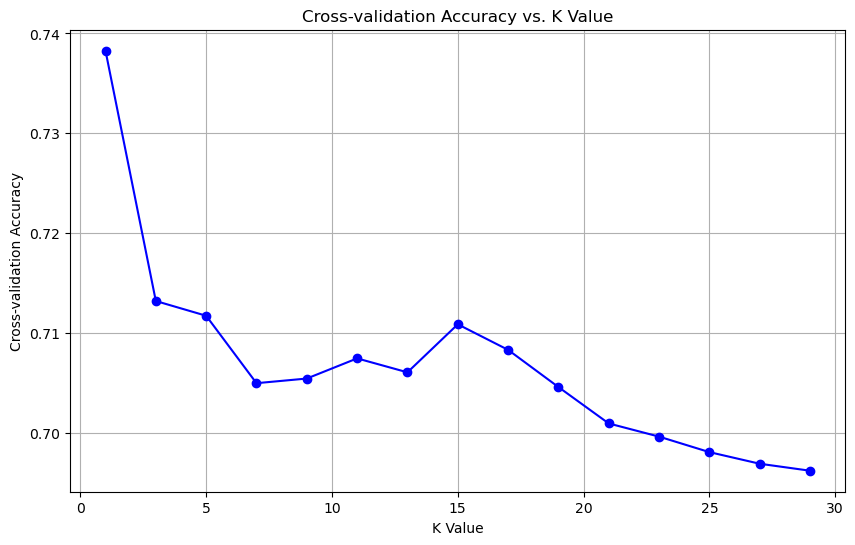


Optimal K value: 1
Best cross-validation accuracy: 0.7383

Training KNN with optimal K...

Test Set Accuracy: 0.5591

Classification Report:
              precision    recall  f1-score   support

     Control       0.48      0.35      0.40      1640
        ADHD       0.60      0.71      0.65      2209

    accuracy                           0.56      3849
   macro avg       0.54      0.53      0.53      3849
weighted avg       0.55      0.56      0.55      3849


Plotting confusion matrix...


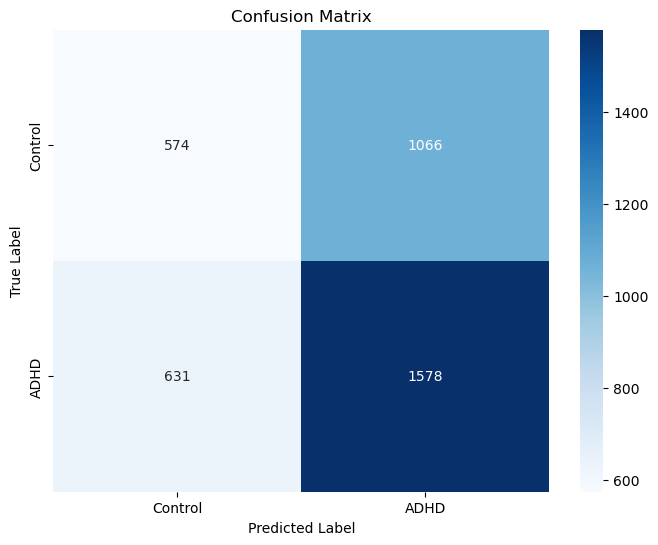


Performing grid search for hyperparameter tuning...


c:\Users\saman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\saman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\saman\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\saman\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\saman\anaconda3\Lib\site-packages


Grid Search Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}
Best cross-validation accuracy: 0.7404

Training final model with best parameters...

Final Model Results:
Test Set Accuracy: 0.6267

Classification Report:
              precision    recall  f1-score   support

     Control       0.57      0.53      0.55      1640
        ADHD       0.67      0.70      0.68      2209

    accuracy                           0.63      3849
   macro avg       0.62      0.61      0.62      3849
weighted avg       0.62      0.63      0.62      3849


Plotting final confusion matrix...


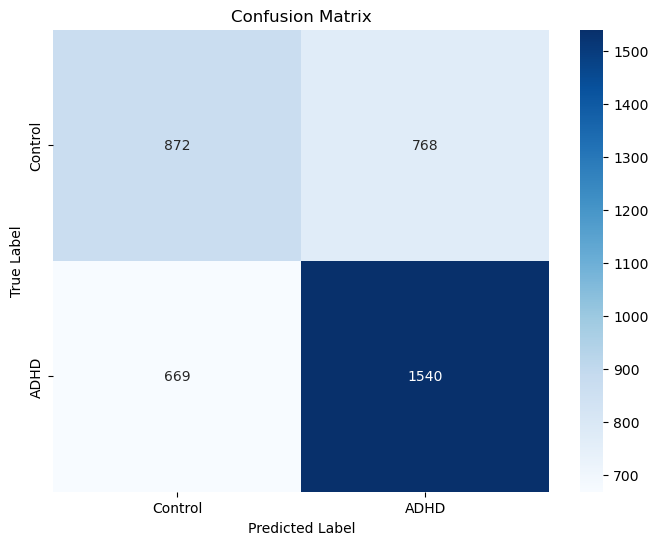


Model and scaler saved as 'knn_model.joblib' and 'knn_scaler.joblib'


In [13]:


def find_optimal_k(X_train, y_train, k_range=range(1, 31, 2)):
    """
    Find the optimal K value using cross-validation
    """
    cv_scores = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, cv_scores, 'bo-')
    plt.title('Cross-validation Accuracy vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Cross-validation Accuracy')
    plt.grid(True)
    plt.show()
    
    # Get the optimal K value
    optimal_k = k_range[np.argmax(cv_scores)]
    print(f"\nOptimal K value: {optimal_k}")
    print(f"Best cross-validation accuracy: {max(cv_scores):.4f}")
    
    return optimal_k

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Control', 'ADHD'],
        yticklabels=['Control', 'ADHD']
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main():
    # Load the pre-split data
    print("Loading pre-split train and test features...")
    train_df = pd.read_csv('eeg_train_features.csv')
    test_df = pd.read_csv('eeg_test_features.csv')
    
    # Separate features and labels
    X_train = train_df[['slow_power_ch0', 'slow_ch0', 'slow_power_ch1', 'slow_ch1', 'slow_power_ch2', 'slow_ch2',
                        'slow_power_ch3', 'slow_ch3', 'slow_power_ch4', 'slow_ch4', 'slow_power_ch5', 'slow_ch5', 
                        'slow_power_ch6', 'slow_ch6', 'slow_power_ch7', 'slow_ch7', 'slow_power_ch8','slow_ch8', 
                        'slow_power_ch9', 'slow_ch9', 'slow_power_ch10', 'slow_ch10', 'slow_power_ch11',  'slow_ch11',
                        'slow_power_ch12', 'slow_ch12', 'slow_power_ch13', 'slow_ch13', 'slow_power_ch14', 'slow_ch14', 
                        'slow_power_ch15', 'slow_ch15', 'slow_power_ch16', 'slow_ch16', 'slow_power_ch17', 'slow_ch17',
                        'slow_power_ch18', 'slow_ch18']]
    y_train = train_df['label']
    X_test = test_df[['slow_power_ch0', 'slow_ch0', 'slow_power_ch1', 'slow_ch1', 'slow_power_ch2', 'slow_ch2',
                        'slow_power_ch3', 'slow_ch3', 'slow_power_ch4', 'slow_ch4', 'slow_power_ch5', 'slow_ch5', 
                        'slow_power_ch6', 'slow_ch6', 'slow_power_ch7', 'slow_ch7', 'slow_power_ch8','slow_ch8', 
                        'slow_power_ch9', 'slow_ch9', 'slow_power_ch10', 'slow_ch10', 'slow_power_ch11',  'slow_ch11',
                        'slow_power_ch12', 'slow_ch12', 'slow_power_ch13', 'slow_ch13', 'slow_power_ch14', 'slow_ch14', 
                        'slow_power_ch15', 'slow_ch15', 'slow_power_ch16', 'slow_ch16', 'slow_power_ch17', 'slow_ch17',
                        'slow_power_ch18', 'slow_ch18']]
    y_test = test_df['label']
    
    print("\nData shapes:")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Find optimal K value
    print("\nFinding optimal K value...")
    optimal_k = find_optimal_k(X_train_scaled, y_train)
    
    # Train KNN with optimal K
    print("\nTraining KNN with optimal K...")
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Set Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Control', 'ADHD']))
    
    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(y_test, y_pred)
    
    # Perform grid search for fine-tuning
    print("\nPerforming grid search for hyperparameter tuning...")
    param_grid = {
        'n_neighbors': [optimal_k-2, optimal_k-1, optimal_k, optimal_k+1, optimal_k+2],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print("\nGrid Search Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    print("\nTraining final model with best parameters...")
    best_knn = KNeighborsClassifier(**grid_search.best_params_)
    best_knn.fit(X_train_scaled, y_train)
    
    # Evaluate final model
    final_predictions = best_knn.predict(X_test_scaled)
    final_accuracy = accuracy_score(y_test, final_predictions)
    
    print("\nFinal Model Results:")
    print(f"Test Set Accuracy: {final_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, final_predictions, target_names=['Control', 'ADHD']))
    
    # Plot final confusion matrix
    print("\nPlotting final confusion matrix...")
    plot_confusion_matrix(y_test, final_predictions)
    
    # Save the best model and scaler
    import joblib
    joblib.dump(best_knn, 'knn_model.joblib')
    joblib.dump(scaler, 'knn_scaler.joblib')
    print("\nModel and scaler saved as 'knn_model.joblib' and 'knn_scaler.joblib'")

if __name__ == '__main__':
    main()